<a href="https://colab.research.google.com/github/rm-wu/homework_MLDL/blob/master/HW2/HW2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2**

## 0.A Preliminary Steps


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Install dependencies

In [ ]:
#!pip3 install 'torch==1.4.0'
#!pip3 install 'torchvision==0.5.0'n
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 634kB 3.5MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110277 sha256=b9a57233a0c6582ead74903ee2ac065cfde45a92e5fe35c93ef4c64859816d6f
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


#### Import libraries

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

#### Clone repository

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
	!git clone https://github.com/rm-wu/Homework2-Caltech101.git
	!mv 'Homework2-Caltech101' 'Caltech101'

from Caltech101.caltech_dataset import Caltech

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9280, done.
remote: Total 9280 (delta 0), reused 0 (delta 0), pack-reused 9280
Receiving objects: 100% (9280/9280), 129.49 MiB | 39.00 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (9149/9149), done.


## 0.B Utils functions



### Training Function

In [ ]:
#import time # TODO: benchmark time?
#TODO: add early_stopping argument
#TODO: modify based on optimizer
#TODO: dataloader cannot be None as default

# TODO: OCL done
# TODO: CosineAnnealingWarmRestarts done 

def train_model(model,dataloader, criterion, optimizer, scheduler=None, num_epochs=30,
                early_stopping=False, threshold=0.0, patience=None,
                save_weights=False, path=None):
    if early_stopping:
        if not isinstance(threshold, float):
            raise ValueError("If early_stopping is True threshold must be a valid float value")
        if patience==None:
            patience = 1
        elif not isinstance(patience, int):
            raise ValueError("patience must be an integer")
        patience_count = 0
    
    OCLR_scheduler = isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)
    plateau_scheduler = isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)
    Cosine_scheduler = isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts)
    if plateau_scheduler or scheduler == None:
        print_lr = False
    else:
        print_lr = True

    cudnn.benchmark
    model.to(DEVICE)

    # Best model values
    best_model_w = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss  = 1e9
    
    # Train/validation history
    val_info = [[], []]
    train_info = [[], []]
    
    iters = len(dataloader['train'])
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}", end=" ")
        if print_lr:
            print(f"LR = {scheduler.get_last_lr()}")
        else:
            print()
        print('=' * 50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for i, (images, labels) in enumerate(dataloader[phase]):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if OCLR_scheduler:
                            scheduler.step() # OCL step
                        elif Cosine_scheduler:
                            scheduler.step(epoch + i / iters) # Cosine step


                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

                del images
                del labels
            torch.cuda.empty_cache()

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            
            if phase == 'val' and not OCLR_scheduler and not Cosine_scheduler:
                if plateau_scheduler:
                    # use as a threshold the difference 
                    # print(epoch_loss-train_info[0][epoch]) #TODO: remove
                    scheduler.step(epoch_loss-train_info[0][epoch])
                elif scheduler is not None:
                    scheduler.step()

            if phase == 'train':
                train_info[0].append(epoch_loss)
                train_info[1].append(epoch_acc.item())
            else:
                val_info[0].append(epoch_loss)
                val_info[1].append(epoch_acc.item())
            
            print(f"{phase}\tLoss: {epoch_loss:.4f}\tAcc: {epoch_acc:.4f}")

            if phase=='val' and early_stopping :
                if epoch > 0 and best_loss - threshold < epoch_loss:
                #if epoch > 0 and val_info[0][epoch-1] - threshold < epoch_loss:
                #if (epoch_loss - train_info[0][epoch] ) > threshold:
                    patience_count += 1
                    print(best_loss-threshold, " ", epoch_loss)
                    print("patience_count ", patience_count)
                else:
                    patience_count = 0
            
            if phase == 'val'and epoch_loss < best_loss:
                print(f"new best {epoch_loss:.4f} {best_loss:.4f}")
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_w = copy.deepcopy(model.state_dict())
                if save_weights:
                    torch.save(net.state_dict(), path)
            
        if early_stopping:
            if patience == patience_count:
                break
        print()
    
    print(f'Best val Loss: {best_loss:4f} with Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_w)
    model.to('cpu')
    # return loss and accuracy 
    hist = {"train": {"loss": train_info[0], "acc": train_info[1]},
            "val": {"loss": val_info[0], "acc": val_info[1]}}
    return model, hist


### Evaluation on Test set

In [ ]:
def evaluate_test_set(model, test_dataloader):
    model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    model.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = model(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    #print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

### Accuracy and Loss plotter


In [ ]:
def plot_loss_accuracy(hist):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    epochs = len(hist["train"]["loss"])
    #plot loss 
    ax[0].plot(range(epochs), hist["train"]["loss"])
    ax[0].plot(range(epochs), hist["val"]["loss"])
    #ax[0].set_ylim(0,5)
    ax[0].set_xlim(0, epochs-0.5)
    ax[0].set_title("Loss function")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend(["train loss", "val loss"])
    #ax[0].set_xticks(range(0, epochs, 5))

    #plot accuracy
    ax[1].plot(range(epochs), hist["train"]["acc"])
    ax[1].plot(range(epochs), hist["val"]["acc"])
    #ax[1].set_ylim(0, 1)
    ax[1].set_xlim(0, epochs-0.5)
    ax[1].set_title("Accuracy score")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend(["train acc", "val acc"])

    #ax[0].set_xticks(range(0, epochs, 5))


### Save Results


In [ ]:
def save_results(result, filename):
    with open(filename, "w", encoding="utf-8") as f:
        f.write("train_loss, val_loss, train_acc, val_acc\n")
        epochs = len(result["train"]["loss"])
        for i in range(epochs):
            f.write(f"{result['train']['loss'][i]},"
                    f"{result['val']['loss'][i]},"
                    f"{result['train']['acc'][i]},"
                    f"{result['val']['acc'][i]}\n")

# 1 - Data Preparation

In [ ]:
DEVICE = 'cuda'     # 'cuda' or 'cpu'

NUM_CLASSES = 101 #102   # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results
                    
norm_caltech101_mean = (0.5, 0.5, 0.5)
norm_caltech101_std  = (0.5, 0.5, 0.5)


norm_imagenet_mean = (0.485, 0.456, 0.406)
norm_imagenet_std  = (0.229, 0.224, 0.225)

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(norm_caltech101_mean, norm_caltech101_std) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_caltech101_mean, norm_caltech101_std)                                    
])

In [ ]:
from torch.utils.data import Dataset
class MySubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, idx):
        im, label = self.dataset[self.indices[idx]]
        return self.transform(im), label
    
    def __len__(self):
        return len(self.indices)

In [ ]:
DATA_DIR = './Caltech101'


# Prepare Pytorch train/test Datasets
train_dataset_ = Caltech(DATA_DIR, split='train',  transform=None)
test_dataset= Caltech(DATA_DIR, split='test', transform=eval_transform)

train_idx, val_idx = train_test_split(np.arange(0, len(train_dataset_)), train_size=0.5,
									shuffle=True, stratify=train_dataset_.y)

train_dataset = MySubset(train_dataset_, train_idx, train_transform)
val_dataset = MySubset(train_dataset_, val_idx, eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
l , counts_ = np.unique(np.take(train_dataset_.y, train_idx), return_counts=True)
weights = torch.Tensor(np.min(counts_)/counts_)

## 1.1 - Label distribution

In [ ]:
y = train_dataset_.y + test_dataset.y
print(f"Dataset dimension : {len(y)} images")

Dataset dimension : 8677 images


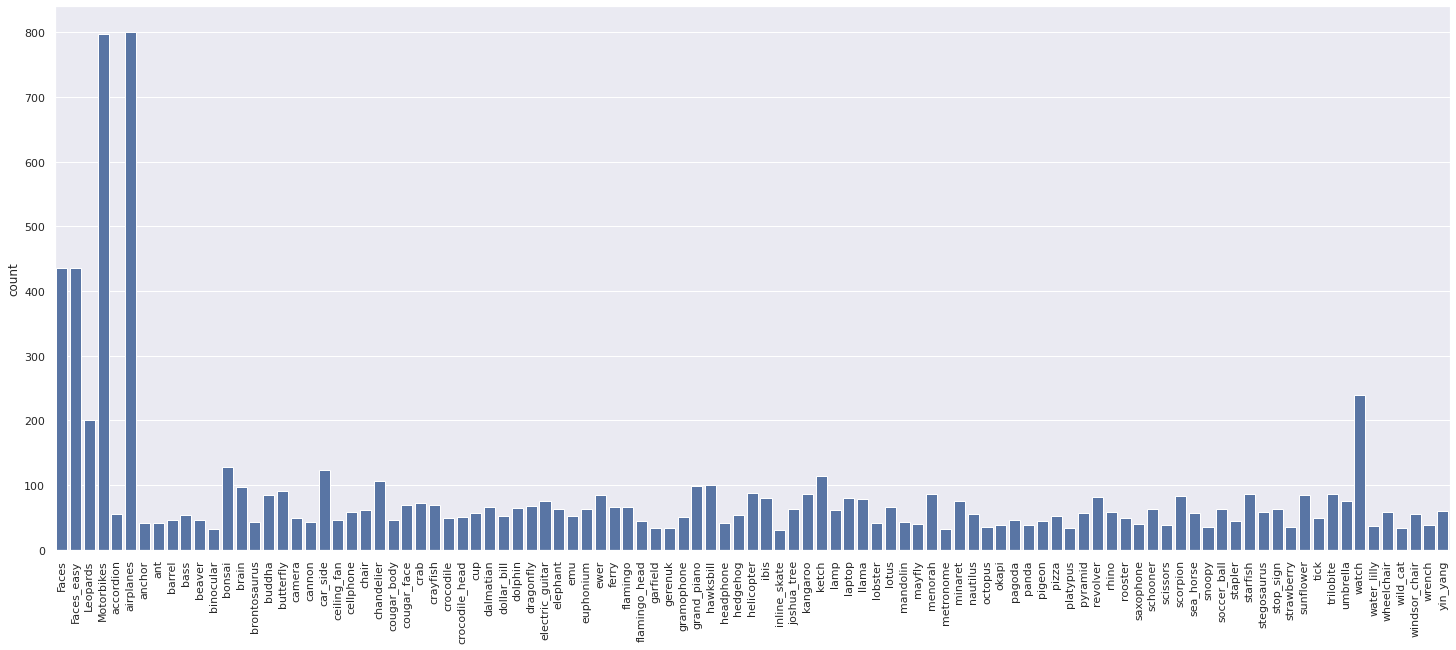

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))

sns.countplot(y, color='b')
ax.set(
    #xticks=range(len(train_dataset_.categories)), 
    xticklabels=train_dataset_.categories)
ax.xaxis.set_tick_params(rotation=90);

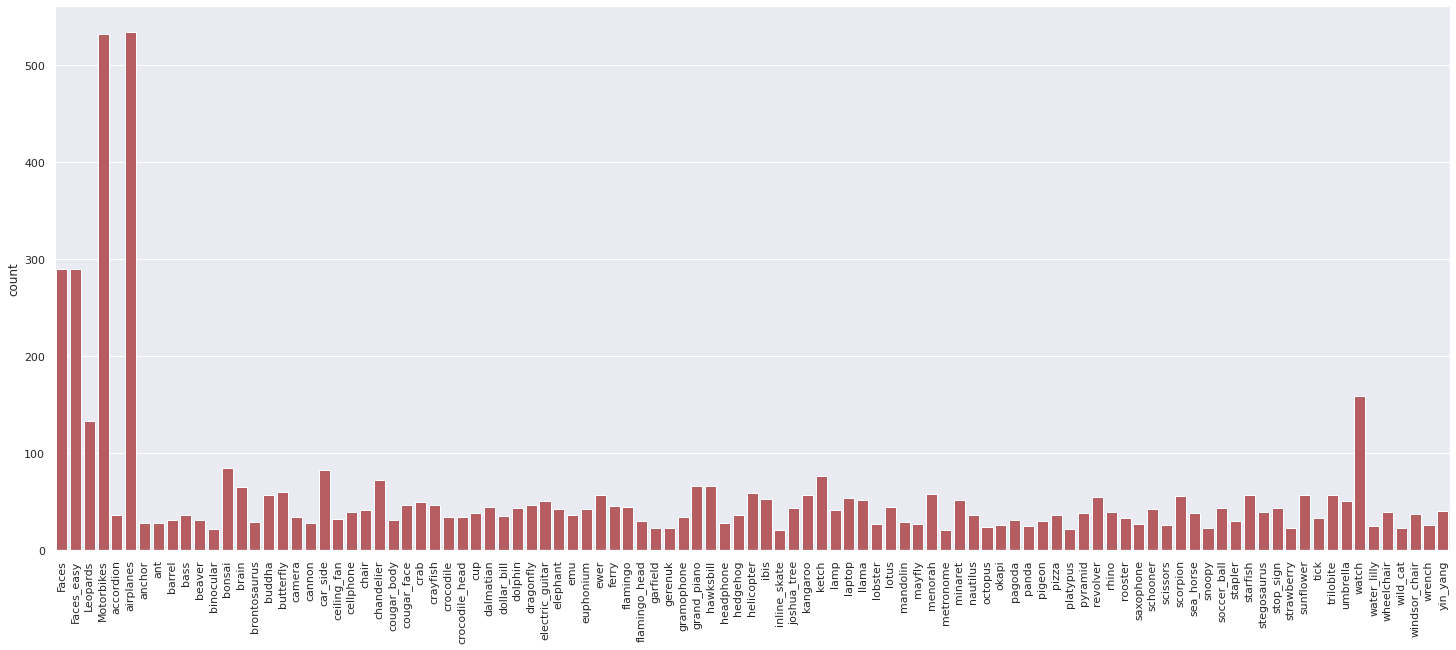

In [ ]:
#TODO: add a visualization that shows class distribution in train and validation set
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(train_dataset_.y, color='r')
ax.set(
    #xticks=range(len(train_dataset_.categories)), 
    xticklabels=train_dataset_.categories, )
ax.xaxis.set_tick_params(rotation=90);

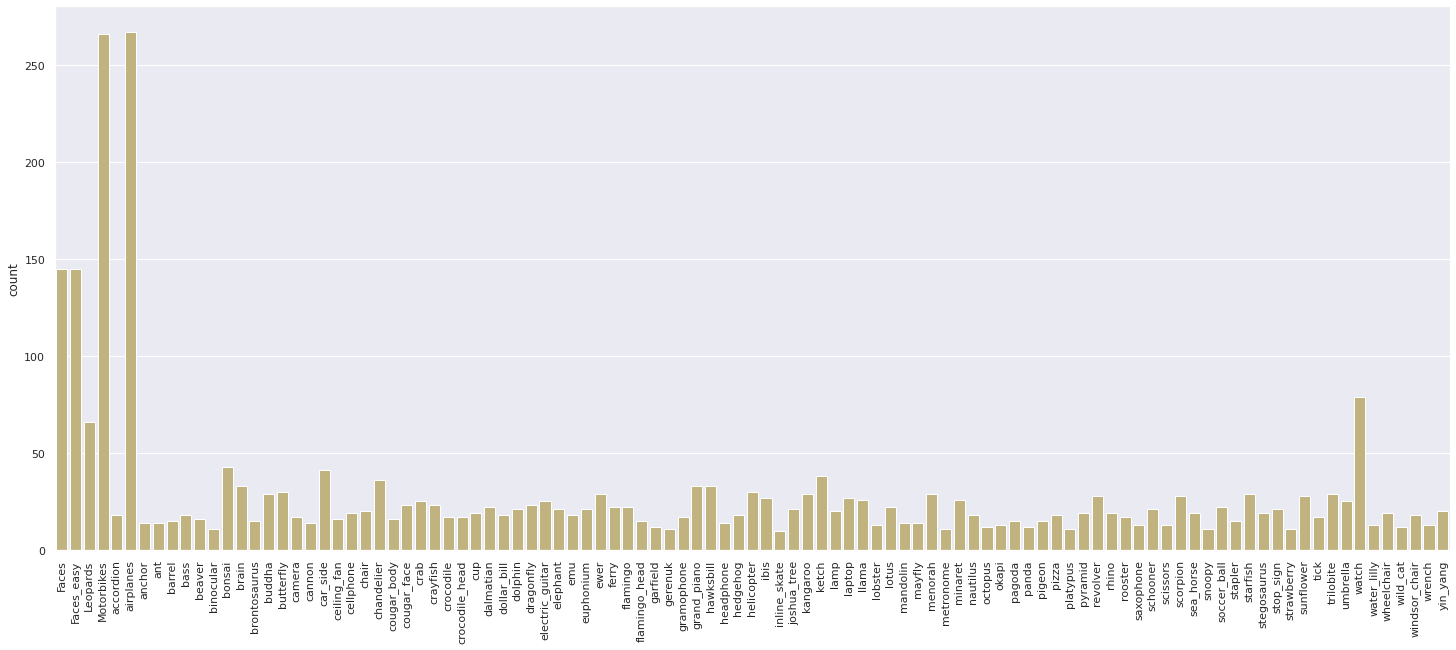

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))

sns.countplot(np.take(train_dataset_.y, train_idx), color='y')
ax.set(
    #xticks=range(len(train_dataset_.categories)), 
    xticklabels=train_dataset_.categories, )
ax.xaxis.set_tick_params(rotation=90);

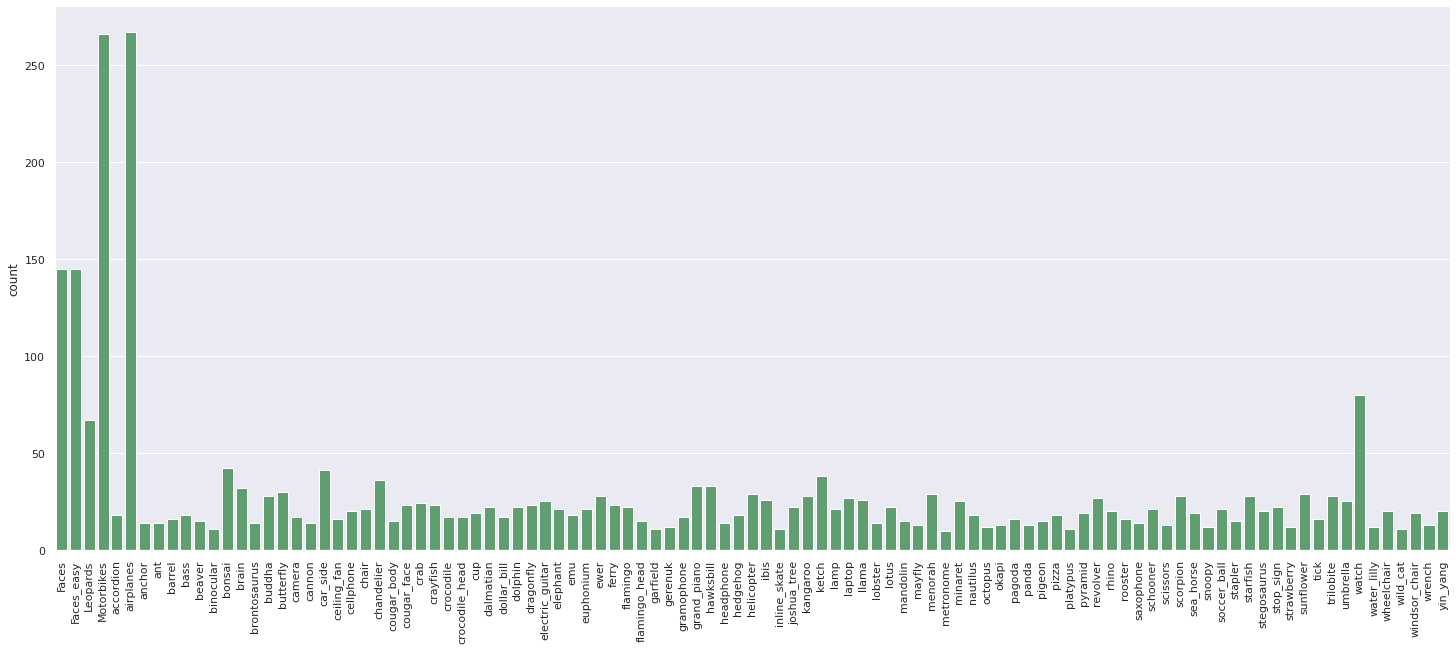

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))

sns.countplot(np.take(train_dataset_.y, val_idx), color='g')
ax.set(
    #xticks=range(len(train_dataset_.categories)), 
    xticklabels=train_dataset_.categories, )
ax.xaxis.set_tick_params(rotation=90);

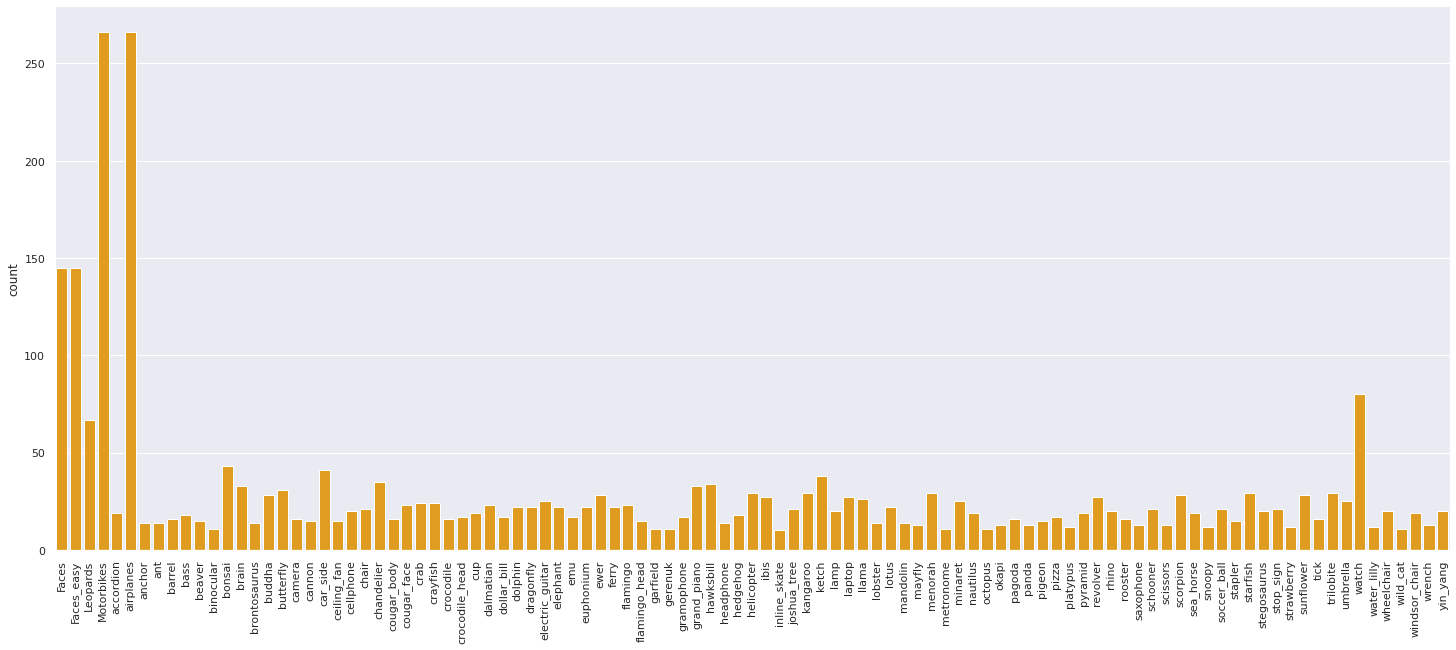

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))

sns.countplot(test_dataset.y, color='orange')
ax.set(
    #xticks=range(len(train_dataset_.categories)), 
    xticklabels=test_dataset.categories, )
ax.xaxis.set_tick_params(rotation=90);

# 2 - Training from scratch

In [ ]:
LR = 1e-3           # The initial Learning Rate
MOMENTUM = 0.9      # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5 # Regularization, you can keep this at the default

NUM_EPOCHS = 30     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

dataloader = {'train': train_dataloader, 'val': val_dataloader}
dataset = {'train': train_dataset, 'val': val_dataset}

### 2.1 SGD

#### 2.1.1 - Scratch Basic Argument values

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
model_scratch_1, scratch_res_1 = train_model(net,dataloader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Epoch 1/30 LR = [0.001]
train	Loss: 4.4944	Acc: 0.0076
val	Loss: 4.6147	Acc: 0.0097
new best 4.6147 1000000000.0000

Epoch 2/30 LR = [0.001]
train	Loss: 4.4922	Acc: 0.0093
val	Loss: 4.6120	Acc: 0.0097
new best 4.6120 4.6147

Epoch 3/30 LR = [0.001]
train	Loss: 4.4895	Acc: 0.0418
val	Loss: 4.6091	Acc: 0.0934
new best 4.6091 4.6120

Epoch 4/30 LR = [0.001]
train	Loss: 4.4865	Acc: 0.1041
val	Loss: 4.6059	Acc: 0.1065
new best 4.6059 4.6091

Epoch 5/30 LR = [0.001]
train	Loss: 4.4833	Acc: 0.1089
val	Loss: 4.6028	Acc: 0.1276
new best 4.6028 4.6059

Epoch 6/30 LR = [0.001]
train	Loss: 4.4805	Acc: 0.1003
val	Loss: 4.5996	Acc: 0.1362
new best 4.5996 4.6028

Epoch 7/30 LR = [0.001]
train	Loss: 4.4771	Acc: 0.1058
val	Loss: 4.5964	Acc: 0.1546
new best 4.5964 4.5996

Epoch 8/30 LR = [0.001]
train	Loss: 4.4739	Acc: 0.1075
val	Loss: 4.5931	Acc: 0.1563
new best 4.5931 4.5964

Epoch 9/30 LR = [0.001]
train	Loss: 4.4709	Acc: 0.1093
val	Loss: 4.5897	Acc: 0.1359
new best 4.5897 4.5931

Epoch 10/30 LR = [0

In [ ]:
plot_loss_accuracy(scratch_res_1)

NameError: ignored

In [ ]:
evaluate_test_set(model_scratch_1, test_dataloader)

Test Accuracy: 0.09194607673695127


#### 2.1.2 SGD w/ different Learning Rates


In [ ]:
LR_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
LR_fnames = ["1e-4", "5e-4", "1e-3", "5e-3", "1e-2", "5e-2", "1e-1"]
MOMENTUM = 0.9      
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30
#GAMMA = 0.1

results = []
models = []

test_acc_list = []

In [ ]:
for i, lr in enumerate(LR_list):
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    print(f"model {i} LR: {lr}")
    model, res = train_model(net,
                             dataloader,
                             criterion,
                             optimizer,
                             #scheduler,
                             num_epochs=NUM_EPOCHS,
                             #early_stopping=True, patience=5, threshold=0.5
                             )
    save_results(res, os.path.join(drive_path, f"FS_sgdLR_lr{LR_fnames[i]}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


model 0 LR: 0.0001
Epoch 1/30 
train	Loss: 4.4931	Acc: 0.0083
val	Loss: 4.6143	Acc: 0.0076
new best 4.6143 1000000000.0000

Epoch 2/30 
train	Loss: 4.4929	Acc: 0.0066
val	Loss: 4.6140	Acc: 0.0076
new best 4.6140 4.6143

Epoch 3/30 
train	Loss: 4.4925	Acc: 0.0076
val	Loss: 4.6137	Acc: 0.0076
new best 4.6137 4.6140

Epoch 4/30 
train	Loss: 4.4922	Acc: 0.0145
val	Loss: 4.6134	Acc: 0.0076
new best 4.6134 4.6137

Epoch 5/30 
train	Loss: 4.4921	Acc: 0.0149
val	Loss: 4.6131	Acc: 0.0076
new best 4.6131 4.6134

Epoch 6/30 
train	Loss: 4.4916	Acc: 0.0187
val	Loss: 4.6128	Acc: 0.0076
new best 4.6128 4.6131

Epoch 7/30 
train	Loss: 4.4914	Acc: 0.0277
val	Loss: 4.6125	Acc: 0.0100
new best 4.6125 4.6128

Epoch 8/30 
train	Loss: 4.4911	Acc: 0.0318
val	Loss: 4.6122	Acc: 0.0591
new best 4.6122 4.6125

Epoch 9/30 
train	Loss: 4.4908	Acc: 0.0494
val	Loss: 4.6119	Acc: 0.0927
new best 4.6119 4.6122

Epoch 10/30 
train	Loss: 4.4906	Acc: 0.0574
val	Loss: 4.6116	Acc: 0.0920
new best 4.6116 4.6119

Epoch 11/30

In [ ]:
print("Test Accuracies: ")
for lr, t_acc in zip(LR_fnames, test_accuracy_list):
    print(f"lr: {lr}\t test accuracy: {t_acc}") 

Test Accuracies: 


NameError: ignored

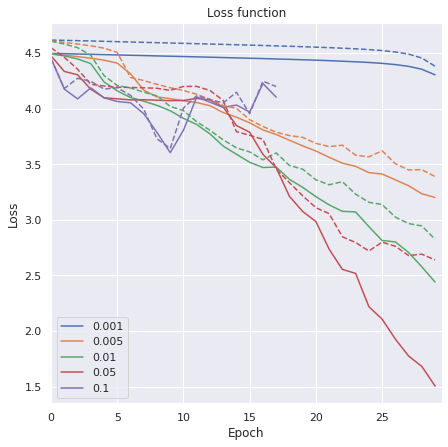

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
#ls = {'train':'--', 'val':'-'}
for phase in ['train', 'val']:
    for res in results:
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[phase]["loss"], ls = '--', alpha = 0.5)
        else:
            ax.plot(range(epochs), res[phase]["loss"], ls = '-')
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(LR_fname)


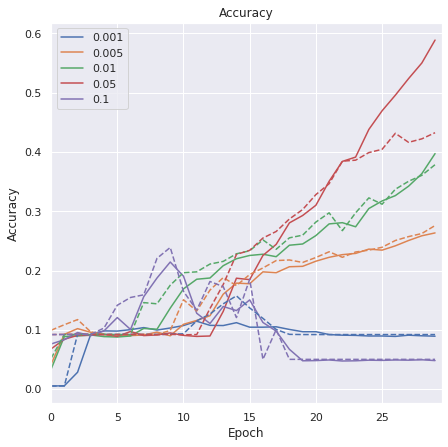

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'-', 'val':'--'}
for phase in ['train', 'val']:
    for res in results:
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        ax.plot(range(epochs), res[phase]["acc"], ls = ls[phase] )
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Accuracy")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(LR_list)

In [ ]:
for i, lr in enumerate(LR_list):
    print(f"{lr} : ", end='')
    evaluate_test_set(models[i], test_dataloader)

0.001 : Test Accuracy: 0.09194607673695127
0.005 : Test Accuracy: 0.26650535776011064
0.01 : Test Accuracy: 0.3740062219149672
0.05 : Test Accuracy: 0.43034911856204633
0.1 : Test Accuracy: 0.2371240926374006


#### TODO:delete

In [ ]:
# Paramaters used in the training for ImageNet by PyTorch
LR = 1e-2           # The initial Learning Rate
MOMENTUM = 0.9      # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5 # Regularization, you can keep this at the default

NUM_EPOCHS = 40     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 30      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
model_scratch_2, scratch_res_2 = train_model(net,
                                             dataloader,
                                             criterion, 
                                             optimizer, 
                                             #scheduler,
                                             num_epochs=NUM_EPOCHS,
                                             #early_stopping=True, patience=5, threshold=0.5
                                             )

Epoch 1/40 
train	Loss: 4.4898	Acc: 0.0526
val	Loss: 4.6024	Acc: 0.0923
new best 4.6024 1000000000.0000

Epoch 2/40 
train	Loss: 4.4713	Acc: 0.0902
val	Loss: 4.5765	Acc: 0.0923
new best 4.5765 4.6024

Epoch 3/40 
train	Loss: 4.4416	Acc: 0.0916
val	Loss: 4.5418	Acc: 0.0923
new best 4.5418 4.5765

Epoch 4/40 
train	Loss: 4.3869	Acc: 0.1148
val	Loss: 4.4212	Acc: 0.0920
new best 4.4212 4.5418

Epoch 5/40 
train	Loss: 4.2237	Acc: 0.0847
val	Loss: 4.3406	Acc: 0.0923
new best 4.3406 4.4212

Epoch 6/40 
train	Loss: 4.1484	Acc: 0.0916
val	Loss: 4.2188	Acc: 0.0920
new best 4.2188 4.3406

Epoch 7/40 
train	Loss: 4.0944	Acc: 0.0906
val	Loss: 4.1826	Acc: 0.1594
new best 4.1826 4.2188

Epoch 8/40 
train	Loss: 4.0685	Acc: 0.1127
val	Loss: 4.1548	Acc: 0.1207
new best 4.1548 4.1826

Epoch 9/40 
train	Loss: 4.0384	Acc: 0.1127
val	Loss: 4.1204	Acc: 0.1366
new best 4.1204 4.1548

Epoch 10/40 
train	Loss: 4.0006	Acc: 0.1373
val	Loss: 4.0606	Acc: 0.1584
new best 4.0606 4.1204

Epoch 11/40 
train	Loss: 3.943

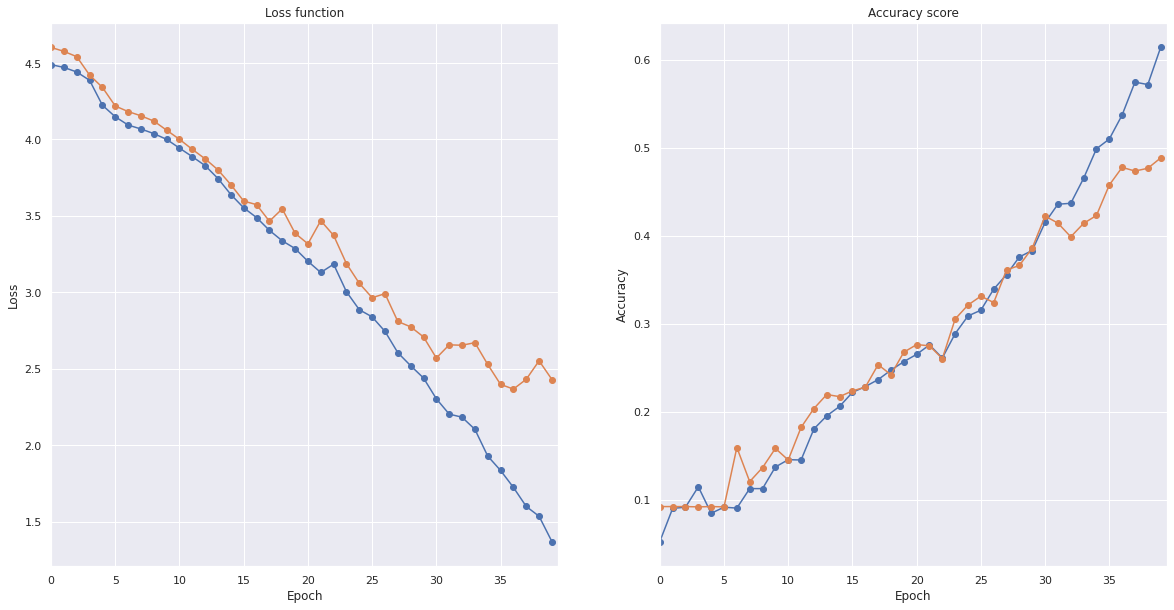

In [ ]:
plot_loss_accuracy(scratch_res_2)

In [ ]:
evaluate_test_set(model_scratch_2, test_dataloader)

Test Accuracy: 0.4697545800207397


#### 2.1.3 SGD w/ different Weight Decay


In [ ]:
LR_list = [0.01, 0.05]
LR_fnames = ["1e-2", "5e-2"]  
WD_list = [0, 5e-5, 5e-4, 5e-3] 
WD_fnames = ["0", "5e-5", "5e-4", "5e-3"]
MOMENTUM = 0.9    
NUM_EPOCHS = 30
results = dict()
models = dict()

In [ ]:
for i, lr in enumerate(LR_list):
    for j, wd in enumerate(WD_list):
        net = alexnet() # Loading AlexNet model
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters() 
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=wd)
        print(f"model{i}_{j} LR: {lr} WD: {wd}")
        model, res = train_model(net,
                                dataloader,
                                criterion,
                                optimizer,
                                #scheduler,
                                num_epochs=NUM_EPOCHS,
                                #early_stopping=True, patience=5, threshold=0.5
                                )
        models[f"{lr}_{wd}"] = model
        results[f"{lr}_{wd}"] = res
        evaluate_test_set(model, test_dataloader)

        save_results(res, f"/content/drive/My Drive/sgdWD_lr{lr}_wd{wd}.csv")

model 0 LR: 0.05 WD: 5e-05
Epoch 1/30 
train	Loss: 4.4712	Acc: 0.0750
val	Loss: 4.5443	Acc: 0.0920
new best 4.5443 1000000000.0000

Epoch 2/30 
train	Loss: 4.3827	Acc: 0.0868
val	Loss: 4.4748	Acc: 0.0923
new best 4.4748 4.5443

Epoch 3/30 
train	Loss: 4.3325	Acc: 0.0902
val	Loss: 4.4038	Acc: 0.0923
new best 4.4038 4.4748

Epoch 4/30 
train	Loss: 4.2474	Acc: 0.0885
val	Loss: 4.3018	Acc: 0.0923
new best 4.3018 4.4038

Epoch 5/30 
train	Loss: 4.1458	Acc: 0.0920
val	Loss: 4.2173	Acc: 0.0923
new best 4.2173 4.3018

Epoch 6/30 
train	Loss: 4.0929	Acc: 0.0896
val	Loss: 4.1985	Acc: 0.0985
new best 4.1985 4.2173

Epoch 7/30 
train	Loss: 4.0822	Acc: 0.0916
val	Loss: 4.1856	Acc: 0.0920
new best 4.1856 4.1985

Epoch 8/30 
train	Loss: 4.0619	Acc: 0.0934
val	Loss: 4.1340	Acc: 0.1694
new best 4.1340 4.1856

Epoch 9/30 
train	Loss: 3.9492	Acc: 0.1539
val	Loss: 3.9676	Acc: 0.1393
new best 3.9676 4.1340

Epoch 10/30 
train	Loss: 3.7900	Acc: 0.1954
val	Loss: 3.7300	Acc: 0.2362
new best 3.7300 3.9676

Epo

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'-', 'val':'--'}
for phase in ['train', 'val']:
    for _, res in results.items():
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        ax.plot(range(epochs), res[phase]["loss"], ls = ls[phase] )
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(WD_list)


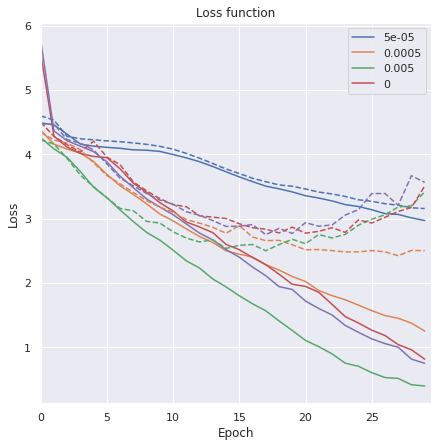

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'-', 'val':'--'}
for phase in ['train', 'val']:
    for _, res in results.items():
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        ax.plot(range(epochs), res[phase]["loss"], ls = ls[phase] )
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(WD_list)

### 2.3 Adam

Test Adam with different learning rates and plot the results


In [ ]:
LR_list = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30
results = dict()
models = dict()

In [ ]:
for i, lr in enumerate(LR_list):
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adam(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=WEIGHT_DECAY)
    print(f"model {i} LR: {lr}")
    model, res = train_model(net,
                             dataloader,
                             criterion,
                             optimizer,
                             #scheduler,
                             num_epochs=NUM_EPOCHS,
                             #early_stopping=True, patience=5, threshold=0.5
                             )
    models[lr] = model
    results[lr] = res
    print()
    print()

    save_results(res, os.path.join(drive_path , f"adam_lr{lr}_wd{WEIGHT_DECAY}.csv"))
    evaluate_test_set(model, test_dataloader)

model 0 LR: 1e-05
Epoch 1/30 
train	Loss: 4.4897	Acc: 0.0432
val	Loss: 4.6006	Acc: 0.0923
new best 4.6006 1000000000.0000

Epoch 2/30 
train	Loss: 4.4605	Acc: 0.1100
val	Loss: 4.5389	Acc: 0.0920
new best 4.5389 4.6006

Epoch 3/30 
train	Loss: 4.3231	Acc: 0.0906
val	Loss: 4.2887	Acc: 0.0920
new best 4.2887 4.5389

Epoch 4/30 
train	Loss: 4.1534	Acc: 0.0899
val	Loss: 4.2318	Acc: 0.0920
new best 4.2318 4.2887

Epoch 5/30 
train	Loss: 4.1135	Acc: 0.1034
val	Loss: 4.2188	Acc: 0.1421
new best 4.2188 4.2318

Epoch 6/30 
train	Loss: 4.1036	Acc: 0.1044
val	Loss: 4.2018	Acc: 0.0920
new best 4.2018 4.2188

Epoch 7/30 
train	Loss: 4.0886	Acc: 0.0896
val	Loss: 4.1890	Acc: 0.0920
new best 4.1890 4.2018

Epoch 8/30 
train	Loss: 4.0678	Acc: 0.0985
val	Loss: 4.1696	Acc: 0.1234
new best 4.1696 4.1890

Epoch 9/30 
train	Loss: 4.0410	Acc: 0.1345
val	Loss: 4.1454	Acc: 0.1438
new best 4.1454 4.1696

Epoch 10/30 
train	Loss: 4.0331	Acc: 0.1404
val	Loss: 4.1104	Acc: 0.1504
new best 4.1104 4.1454

Epoch 11/30 

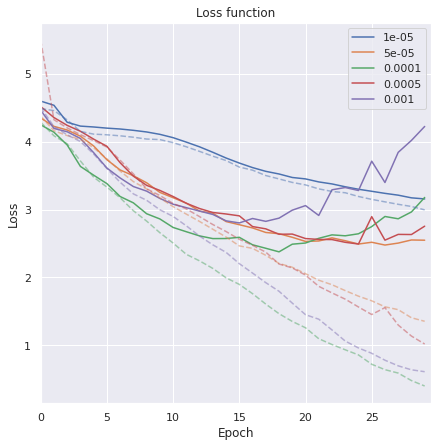

In [ ]:
import csv
def file_res(starts_with=None, files=None):
    if start_with is not  None:
        drive_path = '/content/drive/My Drive'
        files = [f for f in os.listdir(drive_path) if f.startswith(starts_with)]
    #lr_file = [f.split("_")[2][2:] for f in files]
    results = dict()
    for i, f_name in enumerate(files):
        #print(f_name)
        
        res_ = [[], [], [], []]
        with open(os.path.join(drive_path, f_name), "r") as f:
            reader = csv.reader(f)
            next(reader)
            results[i] = {'train':{'loss':[], 'acc':[]},
                        'val':{'loss':[], 'acc':[]}}
            for row in reader:
                results[i]['train']['loss'].append(float(row[0]))
                results[i]['val']['loss'].append(float(row[1]))
                results[i]['train']['acc'].append(float(row[2]))
                results[i]['val']['acc'].append(float(row[3]))
                
            #print(results)
    return results, files

results, files = file_res('adam_')
lr_file = [f.split("_")[1][2:] for f in files]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'--', 'val':'-'}
for phase in ['val', 'train']:
    for res in results.items():
        #print(res)
        epochs = len(res[1]["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase] , alpha=.5)
        else:
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase])
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
    
ax.legend(lr_file)





In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'-', 'val':'--'}
for phase in ['train', 'val']:
    for res in results:
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        ax.plot(range(epochs), res[phase]["loss"], ls = ls[phase] )
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(LR_list)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'-', 'val':'--'}
for phase in ['train', 'val']:
    for res in results:
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        ax.plot(range(epochs), res[phase]["loss"], ls = ls[phase] )
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(LR_list)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'-', 'val':'--'}
for phase in ['train', 'val']:
    for res in results:
        epochs = len(res["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        ax.plot(range(epochs), res[phase]["loss"], ls = ls[phase] )
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
       
ax.legend(LR_list)


In [ ]:
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() 

In [ ]:
optimizer = optim.Adam(net.parameters(), 
                       lr= 1e-4,
                       #amsgrad=True,
                       weight_decay=1e-4)

In [ ]:

#scheduler = optim.lr_scheduler.StepLR(AMSgradOptim, step_size=STEP_SIZE, gamma=GAMMA)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(AMSgradOptim, mode='min', factor=0.1, patience=5,threshold=0.25, verbose=True, min_lr=1e-6)
#model_scratch_3, scratch_res_3 = train_model(net, criterion, AMSgradOptim, scheduler, dataloader)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

#TODO: early stop
model_scratch_3, scratch_res_3 = train_model(net,dataloader,
                                             criterion, 
                                             optimizer, 
                                             None, 
                                             num_epochs=NUM_EPOCHS, 
                                             #early_stopping=True, threshold=0.25, patience=4
                                             )


Epoch 1/1 
train	Loss: 1.3744	Acc: 0.6217
val	Loss: 2.4619	Acc: 0.4872
new best 2.4619 1000000000.0000

Best val Loss: 2.461906 with Acc: 0.487206


In [ ]:
save_results(scratch_res_3, f"adam_lr1e-4_wd1e-4.csv")

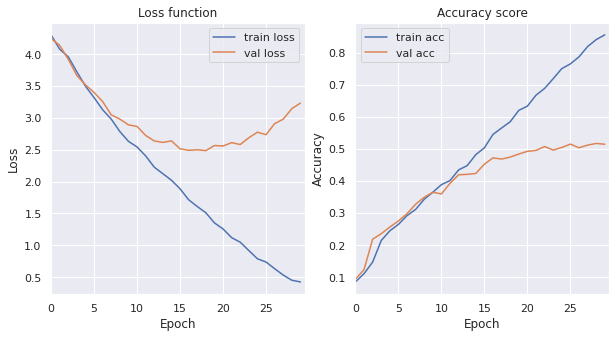

In [ ]:
plot_loss_accuracy(scratch_res_3)

In [ ]:
evaluate_test_set(model_scratch_3, test_dataloader)

Test Accuracy: 0.4808157621845835


### 2.4 AdamW

In [ ]:
LR_list = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30
results = dict()
models = dict()

In [ ]:
for i, lr in enumerate(LR_list):
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.AdamW(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=WEIGHT_DECAY)
    print(f"model {i} LR: {lr}")
    model, res = train_model(net,
                             dataloader,
                             criterion,
                             optimizer,
                             #scheduler,
                             num_epochs=NUM_EPOCHS,
                             #early_stopping=True, patience=5, threshold=0.5
                             )
    models[lr] = model
    results[lr] = res
    print()
    print()

    save_results(res, f"/content/drive/My Drive/adamW_lr{lr}_wd{WEIGHT_DECAY}.csv")
    evaluate_test_set(model, test_dataloader)

model 0 LR: 1e-05
Epoch 1/30 
train	Loss: 4.4881	Acc: 0.0588
val	Loss: 4.5986	Acc: 0.0920
new best 4.5986 1000000000.0000

Epoch 2/30 
train	Loss: 4.4567	Acc: 0.0899
val	Loss: 4.5318	Acc: 0.0920
new best 4.5318 4.5986

Epoch 3/30 
train	Loss: 4.3126	Acc: 0.0889
val	Loss: 4.2776	Acc: 0.0920
new best 4.2776 4.5318

Epoch 4/30 
train	Loss: 4.1580	Acc: 0.0913
val	Loss: 4.2415	Acc: 0.0927
new best 4.2415 4.2776

Epoch 5/30 
train	Loss: 4.1255	Acc: 0.1234
val	Loss: 4.2248	Acc: 0.1342
new best 4.2248 4.2415

Epoch 6/30 
train	Loss: 4.1078	Acc: 0.1086
val	Loss: 4.2085	Acc: 0.0920
new best 4.2085 4.2248

Epoch 7/30 
train	Loss: 4.0930	Acc: 0.0909
val	Loss: 4.1951	Acc: 0.0930
new best 4.1951 4.2085

Epoch 8/30 
train	Loss: 4.0691	Acc: 0.1068
val	Loss: 4.1769	Acc: 0.1279
new best 4.1769 4.1951

Epoch 9/30 
train	Loss: 4.0630	Acc: 0.1397
val	Loss: 4.1545	Acc: 0.1521
new best 4.1545 4.1769

Epoch 10/30 
train	Loss: 4.0446	Acc: 0.1393
val	Loss: 4.1238	Acc: 0.1476
new best 4.1238 4.1545

Epoch 11/30 

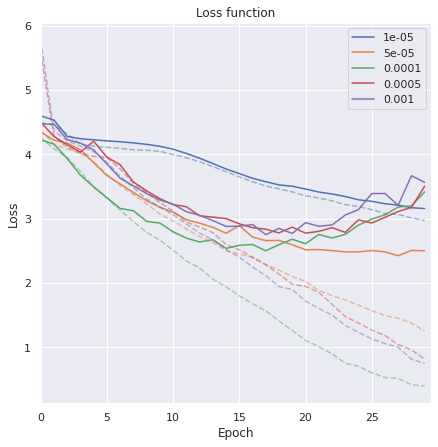

In [ ]:
results, files = file_res('adamW_')
lr_file = [f.split("_")[1][2:] for f in files]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'--', 'val':'-'}
for phase in ['val', 'train']:
    for res in results.items():
        #print(res)
        epochs = len(res[1]["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase] , alpha=.5)
        else:
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase])
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
    
ax.legend(lr_file)

#### 2.4.1 AdamW w/ CosineAnnealingWarmRestarts



In [ ]:
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() 
#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)



In [ ]:
optimizer = optim.AdamW(net.parameters(),
                       lr= 5e-4,
                       #amsgrad=True,
                       weight_decay=1e-4
                       )
#scheduler = optim.lr_scheduler.StepLR(AMSgradOptim, step_size=STEP_SIZE, gamma=GAMMA)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(AMSgradOptim, mode='min', factor=0.1, patience=5,threshold=0.25, verbose=True, min_lr=1e-6)
#model_scratch_3, scratch_res_3 = train_model(net, criterion, AMSgradOptim, scheduler, dataloader)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10)


model_scratch_3_1, scratch_res_3_1 = train_model(net, dataloader, criterion, optimizer, scheduler, num_epochs=60, 
                                             #early_stopping=True, threshold=0.05, patience=5
                                             )


Epoch 1/60 LR = [0.0005]
train	Loss: 4.2358	Acc: 0.0906
val	Loss: 4.2797	Acc: 0.1051
new best 4.2797 1000000000.0000

Epoch 2/60 LR = [0.0004563679742406935]
train	Loss: 4.0435	Acc: 0.1393
val	Loss: 4.0696	Acc: 0.1584
new best 4.0696 4.2797

Epoch 3/60 LR = [0.0004026619699088595]
train	Loss: 3.9163	Acc: 0.1559
val	Loss: 3.9403	Acc: 0.1636
new best 3.9403 4.0696

Epoch 4/60 LR = [0.0003340123483038575]
train	Loss: 3.8016	Acc: 0.1674
val	Loss: 3.9518	Acc: 0.1822

Epoch 5/60 LR = [0.00025713901269842405]
train	Loss: 3.7409	Acc: 0.1947
val	Loss: 3.7207	Acc: 0.2078
new best 3.7207 3.9403

Epoch 6/60 LR = [0.0001795668607896425]
train	Loss: 3.5332	Acc: 0.2102
val	Loss: 3.5664	Acc: 0.2261
new best 3.5664 3.7207

Epoch 7/60 LR = [0.00010888919528330768]
train	Loss: 3.3997	Acc: 0.2320
val	Loss: 3.4819	Acc: 0.2483
new best 3.4819 3.5664

Epoch 8/60 LR = [5.20244385194312e-05]
train	Loss: 3.3334	Acc: 0.2531
val	Loss: 3.4196	Acc: 0.2538
new best 3.4196 3.4819

Epoch 9/60 LR = [1.4538909090118819e

KeyboardInterrupt: ignored

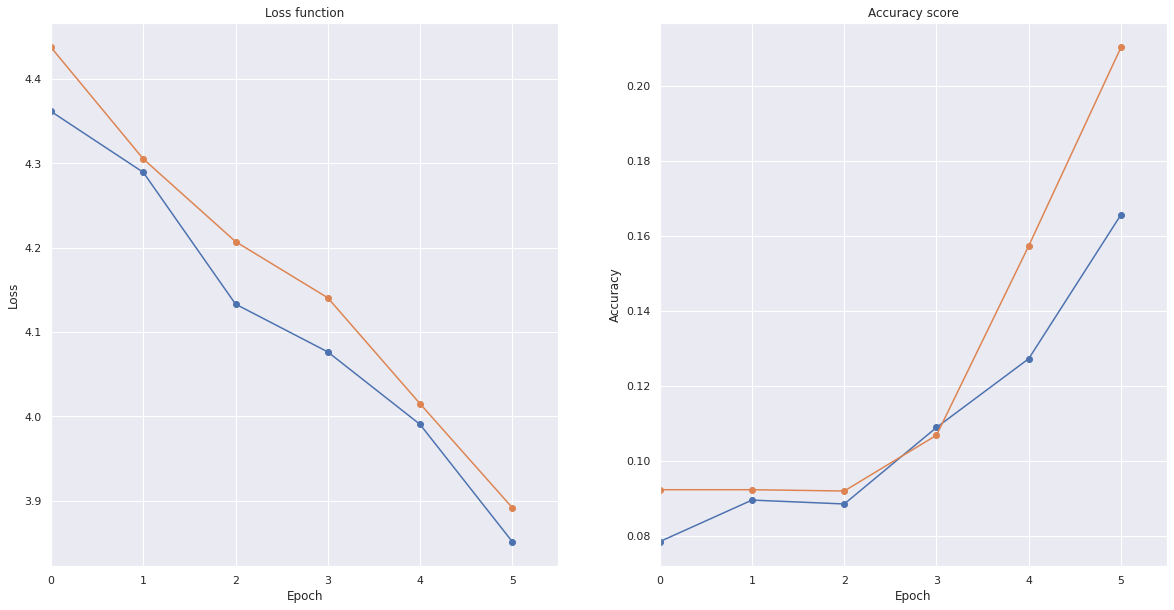

In [ ]:
plot_loss_accuracy(scratch_res_3_1)

In [ ]:
evaluate_test_set(model_scratch_3_1, test_dataloader)

Test Accuracy: 0.208779813342551


#### 2.4.2 - AdamW w/ OneCycleLR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


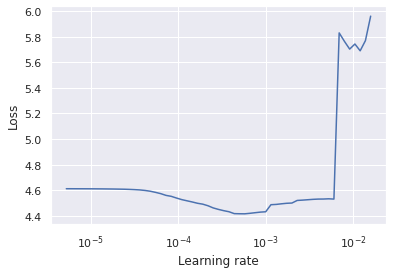

In [ ]:
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
# Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-6, weight_decay=1e-3)

#optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph

lr_finder.reset()

In [ ]:
#optimizer = optim.AdamW(net.parameters(), lr=5e-4, weight_decay=1e-3)
#optimizer = optim.SGD(net.parameters(), lr=4e-2, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
n_epoch = 20
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=n_epoch)

model_scratch_4, scratch_res_4 = train_model(net, dataloader, criterion, optimizer, scheduler, num_epochs=n_epoch, 
                                             early_stopping=True, threshold=0.2, patience=5
                                             )


Epoch 1/20 LR = [1.9999999999999998e-05]
train	Loss: 4.4701	Acc: 0.0754
val	Loss: 4.4915	Acc: 0.0920
new best 4.4915 1000000000.0000

Epoch 2/20 LR = [5.31272799487882e-05]
train	Loss: 4.2138	Acc: 0.0851
val	Loss: 4.2588	Acc: 0.0647
new best 4.2588 4.4915
patience_count  1

Epoch 3/20 LR = [0.00014336398082177458]
train	Loss: 4.0928	Acc: 0.1082
val	Loss: 4.1545	Acc: 0.0934
new best 4.1545 4.2588
patience_count  2

Epoch 4/20 LR = [0.00026579929885667166]
train	Loss: 3.9479	Acc: 0.1563
val	Loss: 3.9875	Acc: 0.1611
new best 3.9875 4.1545
patience_count  3

Epoch 5/20 LR = [0.0003866336585854719]
train	Loss: 3.8567	Acc: 0.1995
val	Loss: 3.6677	Acc: 0.2216
new best 3.6677 3.9875
patience_count  4

Epoch 6/20 LR = [0.00047250944615677035]
train	Loss: 3.5380	Acc: 0.2216
val	Loss: 3.4882	Acc: 0.2472
new best 3.4882 3.6677
patience_count  5
Best val Loss: 3.488158 with Acc: 0.247234


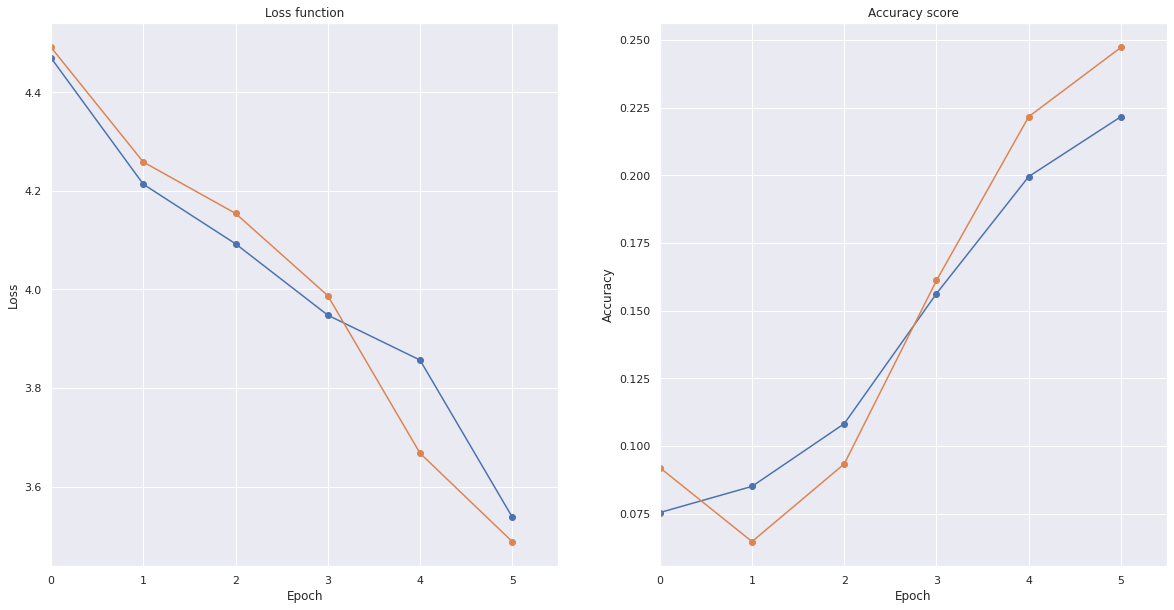

In [ ]:
plot_loss_accuracy(scratch_res_4)

In [ ]:
evaluate_test_set(model_scratch_4, test_dataloader)

Test Accuracy: 0.2464569650881438


# 3 - Transfer Learning

## 3.B Normalize Function ImageNet


In [ ]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(norm_imagenet_mean, norm_imagenet_std) # Normalizes tensor with mean and standard deviation
])
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)                                    
])

train_dataset.transform = train_transform
val_dataset.transform = eval_transform
test_dataset.transform = eval_transform
print(dataloader['train'].dataset.transform)
print(dataloader['val'].dataset.transform)
print(test_dataloader.dataset.transform)



Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [ ]:
#TODO: update only the transform. -> Done

## 3.C Fine Tuning

### 3.C.1 SGD

In [ ]:
net_pretrained = alexnet(pretrained=True)
net_pretrained.classifier[6] = nn.Linear(4096, NUM_CLASSES)

#net_pretrained = net_pretrained.to('cuda')

criterion = nn.CrossEntropyLoss()


In [ ]:
optimizer = optim.SGD(net_pretrained.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=GAMMA)

In [ ]:
model_transfer_1, transfer_res_1 = train_model(net_pretrained, dataloader, criterion, optimizer,
                                               None, 
                                               num_epochs=40,
                                               early_stopping=True, threshold=0.25, patience=5
                                               )

Epoch 1/40 
train	Loss: 3.9835	Acc: 0.1680
val	Loss: 3.2133	Acc: 0.3008
new best 3.2133 1000000000.0000

Epoch 2/40 
train	Loss: 2.7828	Acc: 0.3755
val	Loss: 2.4604	Acc: 0.4889
new best 2.4604 3.2133

Epoch 3/40 
train	Loss: 2.0206	Acc: 0.5239
val	Loss: 1.7833	Acc: 0.5795
new best 1.7833 2.4604

Epoch 4/40 
train	Loss: 1.3338	Acc: 0.6470
val	Loss: 1.2142	Acc: 0.6950
new best 1.2142 1.7833

Epoch 5/40 
train	Loss: 0.8061	Acc: 0.7687
val	Loss: 0.8938	Acc: 0.7645
new best 0.8938 1.2142

Epoch 6/40 
train	Loss: 0.5249	Acc: 0.8354
val	Loss: 0.7696	Acc: 0.7860
0.6437950080690872   0.7695529492234459
patience_count  1
new best 0.7696 0.8938

Epoch 7/40 
train	Loss: 0.3572	Acc: 0.8762
val	Loss: 0.7050	Acc: 0.8046
0.5195529492234459   0.7049539808910418
patience_count  2
new best 0.7050 0.7696

Epoch 8/40 
train	Loss: 0.2504	Acc: 0.9021
val	Loss: 0.6976	Acc: 0.8071
0.4549539808910418   0.6975524054523325
patience_count  3
new best 0.6976 0.7050

Epoch 9/40 
train	Loss: 0.1723	Acc: 0.9336
val	Lo

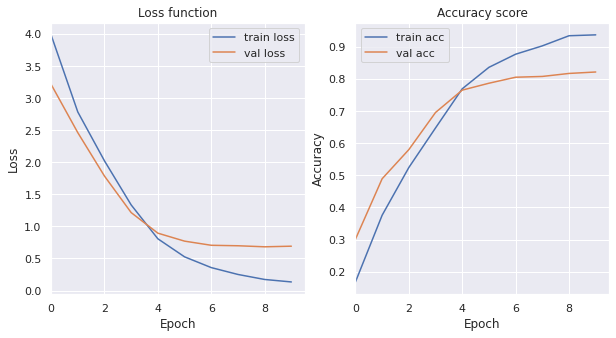

In [ ]:
plot_loss_accuracy(transfer_res_1)

In [ ]:
evaluate_test_set(model_transfer_1, test_dataloader)

Test Accuracy: 0.8185


### 3.C.2 SGD w/  higher Weight Decay

In [ ]:
net_pretrained = alexnet(pretrained=True)
net_pretrained.classifier[6] = nn.Linear(4096, NUM_CLASSES)

#net_pretrained = net_pretrained.to('cuda')

criterion = nn.CrossEntropyLoss()


In [ ]:
optimizer = optim.SGD(net_pretrained.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=1e-4) #TODO: restore 0.001 lr
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=GAMMA)

In [ ]:
model_transfer_1_1, transfer_res_1_1 = train_model(net_pretrained, 
                                                   dataloader,
                                                   criterion, 
                                                   optimizer, 
                                                   None, 
                                                   #scheduler, 
                                                   num_epochs=40,
                                                   early_stopping=True, threshold=0.25, patience=5
                                                   )

Epoch 1/40 
train	Loss: 3.9471	Acc: 0.1649
val	Loss: 3.1972	Acc: 0.2943
new best 3.1972 1000000000.0000

Epoch 2/40 
train	Loss: 2.7513	Acc: 0.3662
val	Loss: 2.4176	Acc: 0.4865
new best 2.4176 3.1972

Epoch 3/40 
train	Loss: 1.9915	Acc: 0.5325
val	Loss: 1.6839	Acc: 0.6155
new best 1.6839 2.4176

Epoch 4/40 
train	Loss: 1.2620	Acc: 0.6629
val	Loss: 1.1167	Acc: 0.7196
new best 1.1167 1.6839

Epoch 5/40 
train	Loss: 0.7420	Acc: 0.7873
val	Loss: 0.8322	Acc: 0.7794
new best 0.8322 1.1167

Epoch 6/40 
train	Loss: 0.4903	Acc: 0.8479
val	Loss: 0.7221	Acc: 0.8036
new best 0.7221 0.8322
patience_count  1

Epoch 7/40 
train	Loss: 0.3362	Acc: 0.8828
val	Loss: 0.6762	Acc: 0.8091
new best 0.6762 0.7221
patience_count  2

Epoch 8/40 
train	Loss: 0.2463	Acc: 0.9094
val	Loss: 0.6540	Acc: 0.8195
new best 0.6540 0.6762
patience_count  3

Epoch 9/40 
train	Loss: 0.1957	Acc: 0.9149
val	Loss: 0.6417	Acc: 0.8181
new best 0.6417 0.6540
patience_count  4

Epoch 10/40 
train	Loss: 0.1358	Acc: 0.9381
val	Loss: 0

In [ ]:
plot_loss_accuracy(transfer_res_1_1)

In [ ]:
evaluate_test_set(model_transfer_1_1, test_dataloader)

### 3.C.3 AdamW w/ OneCycleLR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


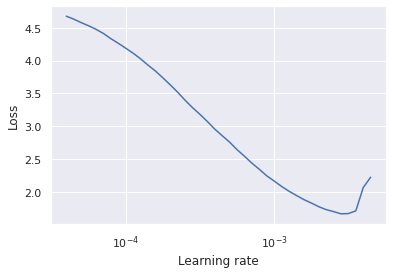

In [ ]:
net_pretrained = alexnet(pretrained=True)
net_pretrained.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net_pretrained.parameters(), lr=1e-5, weight_decay=1e-2)

#optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_finder = LRFinder(net_pretrained, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(net_pretrained.parameters(), lr=5e-4,  weight_decay=1e-3)#, amsgrad=True)
#optimizer = optim.SGD(net_pretrained.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=GAMMA)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(AMSgradOptim, mode='min', factor=0.1, patience=2,threshold=0.25, verbose=True, min_lr=1e-6)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=40)

#optimizer = optim.SGD(net_pretrained.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)


In [ ]:
model_transfer_2, transfer_res_2 = train_model(net_pretrained, dataloader, criterion, optimizer, scheduler, num_epochs=40, 
                                               early_stopping=True, threshold=0.25, patience=5
                                               )
#model_transfer_2, transfer_res_2 = train_model(net_pretrained, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Epoch 1/40 LR = [1.9999999999999998e-05]
train	Loss: 4.2234	Acc: 0.1241
val	Loss: 3.6802	Acc: 0.2735
new best 3.6802 1000000000.0000

Epoch 2/40 LR = [2.8302402559386448e-05]
train	Loss: 3.1219	Acc: 0.2880
val	Loss: 2.6814	Acc: 0.3883
new best 2.6814 3.6802

Epoch 3/40 LR = [5.263519450206169e-05]
train	Loss: 2.0668	Acc: 0.4768
val	Loss: 1.5691	Acc: 0.6089
new best 1.5691 2.6814

Epoch 4/40 LR = [9.131487054384323e-05]
train	Loss: 0.8941	Acc: 0.7389
val	Loss: 0.8519	Acc: 0.7690
new best 0.8519 1.5691

Epoch 5/40 LR = [0.0001416653120066851]
train	Loss: 0.3311	Acc: 0.8759
val	Loss: 0.7031	Acc: 0.8071
new best 0.7031 0.8519
patience_count  1

Epoch 6/40 LR = [0.0002002029386066927]
train	Loss: 0.1250	Acc: 0.9391
val	Loss: 0.7442	Acc: 0.8185
patience_count  2

Epoch 7/40 LR = [0.0002628777258363303]
train	Loss: 0.0921	Acc: 0.9471
val	Loss: 0.8156	Acc: 0.8039
patience_count  3

Epoch 8/40 LR = [0.0003253534127463948]
train	Loss: 0.0817	Acc: 0.9447
val	Loss: 0.8117	Acc: 0.8057
patience_coun

In [ ]:
plot_loss_accuracy(transfer_res_2)

In [ ]:
evaluate_test_set(model_transfer_2, test_dataloader)

## 3.D Convolutional Layers as Feature Extractors

### 3.D.1 SGD

In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
model_conv.classifier[6] = nn.Linear(4096, NUM_CLASSES)
for param in model_conv.classifier.parameters():
    param.requires_grad = True
for param in model_conv.parameters():
    print(param.requires_grad)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) #TODO: original 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [ ]:
model_conv_1, conv_res_1 = train_model(model_conv, dataloader, criterion, 
                                       optimizer, 
                                       #None, 
                                       scheduler, 
                                       num_epochs=NUM_EPOCHS,
                                       early_stopping=True, threshold=0.25, patience=5
                                       )

In [ ]:
plot_loss_accuracy(conv_res_1)

In [ ]:
evaluate_test_set(model_conv_1, test_dataloader)

### 3.D.2 SGD w/ higher Weight Decay

In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

model_conv.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 101),
        )
#model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)

In [ ]:
model_conv_2, conv_res_2 = train_model(model_conv, dataloader,
                                       criterion, 
                                       optimizer, 
                                       #None, 
                                       scheduler,
                                       num_epochs=NUM_EPOCHS, 
                                       early_stopping=True, threshold=0.25, patience=5)

In [ ]:
plot_loss_accuracy(conv_res_2)

In [ ]:
evaluate_test_set(model_conv_2, test_dataloader)

### 3.D.3 AdamW w/ OneCycleLR

In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
model_conv.classifier[6] = nn.Linear(4096, NUM_CLASSES)
for param in model_conv.classifier.parameters():
    param.requires_grad = True
for param in model_conv.parameters():
    print(param.requires_grad)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


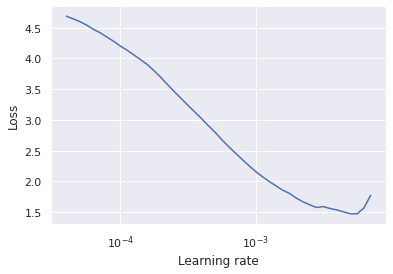

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_conv.parameters(), lr=1e-5, weight_decay=1e-3)

#optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
#optimizer = optim.AdamW(model_conv.parameters(), lr=5e-4,  weight_decay=1e-3)#, amsgrad=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=20)

In [ ]:
model_conv_3, conv_res_3 = train_model(model_conv, dataloader, criterion, 
                                       optimizer, 
                                       #None, 
                                       scheduler, 
                                       num_epochs=20,
                                       early_stopping=True, threshold=0.5, patience=5

                                       )

Epoch 1/20 LR = [1.9999999999999998e-05]


RuntimeError: ignored

In [ ]:
plot_loss_accuracy(conv_res_3)

In [ ]:
evaluate_test_set(model_conv_3, test_dataloader)

## 3.E - Freeze FC Layers 


### 3.E.1 FC all freezed

In [ ]:
model_fc = torchvision.models.alexnet(pretrained=True)
model_fc.classifier[6] = nn.Linear(4096, 101) 
for param in model_fc.classifier.parameters():
    param.requires_grad = False
for par in model_fc.parameters():
    print(par.requires_grad)

True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_fc.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)

In [ ]:
model_fc_1, fc_res_1 = train_model(model_fc, dataloader,
                                       criterion, 
                                       optimizer, 
                                       #None, 
                                       scheduler,
                                       num_epochs=15, 
                                       early_stopping=True, threshold=0.10, patience=5
                                   )

Epoch 1/15 LR = [0.01]
train	Loss: 4.5245	Acc: 0.0290
val	Loss: 4.3844	Acc: 0.0996
new best 4.3844 1000000000.0000

Epoch 2/15 LR = [0.01]
train	Loss: 4.0879	Acc: 0.1639
val	Loss: 3.7330	Acc: 0.2369
new best 3.7330 4.3844

Epoch 3/15 LR = [0.01]
train	Loss: 3.5751	Acc: 0.2379
val	Loss: 3.4598	Acc: 0.2507
new best 3.4598 3.7330

Epoch 4/15 LR = [0.01]
train	Loss: 3.3779	Acc: 0.2445
val	Loss: 3.3320	Acc: 0.2880
new best 3.3320 3.4598

Epoch 5/15 LR = [0.01]
train	Loss: 3.2558	Acc: 0.2711
val	Loss: 3.2323	Acc: 0.3185
3.23200080002327   3.232256755789286
patience_count  1
new best 3.2323 3.3320

Epoch 6/15 LR = [0.01]
train	Loss: 3.1338	Acc: 0.2994
val	Loss: 3.1451	Acc: 0.3371
3.1322567557892858   3.1451171750349625
patience_count  2
new best 3.1451 3.2323

Epoch 7/15 LR = [0.01]
train	Loss: 3.0524	Acc: 0.3202
val	Loss: 3.0621	Acc: 0.3513
3.0451171750349624   3.0620858154850876
patience_count  3
new best 3.0621 3.1451

Epoch 8/15 LR = [0.01]
train	Loss: 2.9874	Acc: 0.3320
val	Loss: 2.9918	

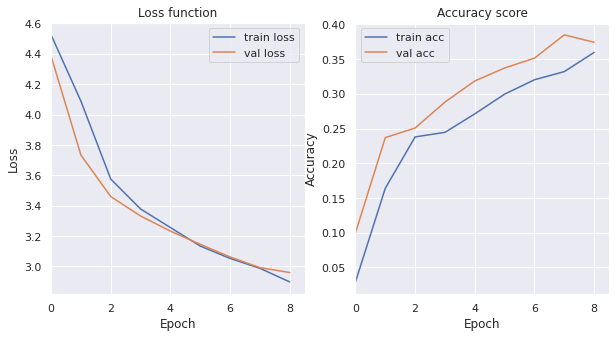

In [ ]:
plot_loss_accuracy(fc_res_1)

In [ ]:
evaluate_test_set(model_fc_1, test_dataloader)

Test Accuracy: 0.3664


### 3.E.1 FC[6] not freezed


In [ ]:
model_fc = torchvision.models.alexnet(pretrained=True)
for param in model_fc.classifier.parameters():
    param.requires_grad = False
model_fc.classifier[6] = nn.Linear(4096, 101) 
# model_fc.classifier[6] and classifier[5] have requires_grad = True, otherwise 
# their parameters will be randomly chosen

for par in model_fc.parameters():
    print(par.requires_grad)

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(model_fc.parameters(), lr=1e-5, weight_decay=1e-3)

optimizer = optim.SGD(model_fc.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_finder = LRFinder(model_fc, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:

criterion = nn.CrossEntropyLoss()

#optimizer = optim.AdamW(model_fc.parameters(), lr=8e-4,  weight_decay=1e-3)#, amsgrad=True)
#optimizer = optim.SGD(net_pretrained.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=GAMMA)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(AMSgradOptim, mode='min', factor=0.1, patience=2,threshold=0.25, verbose=True, min_lr=1e-6)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=8e-3, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=20)

#optimizer = optim.SGD(net_pretrained.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)


In [ ]:
model_fc_3, fc_res_3 = train_model(model_fc, dataloader, criterion, optimizer, scheduler, num_epochs=20, 
                                               early_stopping=True, threshold=0.25, patience=5
                                               )
#model_transfer_2, transfer_res_2 = train_model(net_pretrained, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

In [ ]:
plot_loss_accuracy(fc_res_3)

# 4 - Data Augmentation

In [ ]:
def show_dataset(dataset, n=6):
    fig, ax = plt.subplots(figsize=(20, 20))
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
            for i in range(3)))
    ax.imshow(img)
    plt.axis('off')

t is:  torch.Size([3, 224, 224])


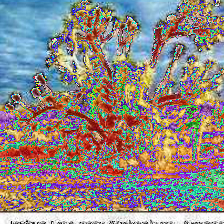

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FBE69E7E9E8>
(224, 224)


In [ ]:
t = dataloader["train"].dataset[2][0]
print("t is: ", t.size())
from torchvision import transforms
im = transforms.ToPILImage()(t).convert("RGB")
display(im)
print(im)
print(im.size)


In [ ]:
def pil_loader(path):
	with open(path, 'rb') as f:
		img = Image.open(f)
		return img.convert('RGB')
image = "Caltech101/101_ObjectCategories/airplanes/image_0021.jpg"

transform = transforms.Compose([
                                #
                                #transforms.RandomAffine([-30.,60.], 
                                #                        translate=(0.01, 0.5),
                                #                         shear=[-0.5, 0.5]),
                                transforms.Resize(256),
                                #transforms.Resize((256, 256)),     
                                #transforms.RandomCrop(),

                                transforms.RandomAffine(10,
                                                        scale=(1, 1.05),
                                                        shear=30),
                                #transforms.Pad(padding=25, padding_mode='edge'),

                                #transforms.ColorJitter(hue=.05, saturation=.05),
                                transforms.ColorJitter(brightness=0.05, 
                                                        contrast=0.05, 
                                                        saturation=0.05, 
                                                        hue=0.05),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(224),
                                #transforms.RandomRotation(20),

                                #transforms.ToTensor(),
                                #transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)
                                ])

transform = transforms.Compose([transforms.Resize(256),
#                                transforms.Resize((256, 256)), 
                                #transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(30),# expand=True, fill=25),
                                transforms.Pad((100, 100, 100, 100), padding_mode='edge'),
                                transforms.CenterCrop(224),
                                transforms.ColorJitter(hue=.1, saturation=.05),
                                ])

img = pil_loader(image)
fig, ax = plt.subplots(1, 5, figsize=(20, 100))
ax[0].imshow(img)
for i in range(1, 5):
    ax[i].imshow(transform(img))


## 4.A RandomHorizontalFlip + Color Jitter

In [ ]:
train_transform_DA1 = transforms.Compose([
                                    #transforms.RandomCrop(200),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize((256, 256)),     
                                    transforms.CenterCrop(224),
                                    transforms.ColorJitter(hue=.05, saturation=.05),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
# Define transforms for the evaluation phase
eval_transform_DA = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
dataloader["train"].dataset.transform = train_transform_DA1
dataloader["val"].dataset.transform = eval_transform_DA
test_dataloader.dataset.transform = eval_transform_DA

In [ ]:
model_DA = torchvision.models.alexnet(pretrained=True)
for param in model_DA.parameters():
    param.requires_grad = False
model_DA.classifier[6] = nn.Linear(4096, NUM_CLASSES)
for param in model_DA.classifier.parameters():
    param.requires_grad = True
for param in model_DA.parameters():
    print(param.requires_grad)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001


In [ ]:
#optimizer = optim.AdamW(model_DA.parameters(), lr=1e-5, weight_decay=1e-3)

optimizer = optim.SGD(model_DA.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_finder = LRFinder(model_DA, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=20)

In [ ]:
model_DA_1, res_DA_1 = train_model(model_DA, dataloader, criterion, optimizer, scheduler, num_epochs=20, 
                                               early_stopping=True, threshold=0.25, patience=5
                                               )

In [ ]:
plot_loss_accuracy(res_DA_1)

In [ ]:
evaluate_test_set(model_DA_1, test_dataloader)

NameError: ignored

## 4.B Random Rotation + Random Horizontal Flip + ColorJitter


In [ ]:
train_transform_DA2 = transforms.Compose([
                                    transforms.Resize((256, 256)), 
                                    #transforms.RandomCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),# expand=True, fill=25),
                                    #transforms.Pad((100, 100, 100, 100), padding_mode='edge'),
                                    transforms.CenterCrop(224),
                                    transforms.ColorJitter(hue=.1, saturation=.05),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
# Define transforms for the evaluation phase
eval_transform_DA = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
dataloader["train"].dataset.transform = train_transform_DA2
dataloader["val"].dataset.transform = eval_transform_DA
test_dataloader.dataset.transform = eval_transform_DA

In [ ]:
model_DA = torchvision.models.alexnet(pretrained=True)
for param in model_DA.parameters():
    param.requires_grad = False
model_DA.classifier[6] = nn.Linear(4096, NUM_CLASSES)
for param in model_DA.classifier.parameters():
    param.requires_grad = True
for param in model_DA.parameters():
    print(param.requires_grad)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001


In [ ]:
optimizer = optim.AdamW(model_DA.parameters(), lr=1e-5, weight_decay=1e-4)
#optimizer = optim.SGD(model_DA.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_finder = LRFinder(model_DA, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=20)

In [ ]:
model_DA_2, res_DA_2 = train_model(model_DA, dataloader, criterion, optimizer, scheduler, num_epochs=20, 
                                               early_stopping=True, threshold=0.25, patience=5
                                               )

In [ ]:
plot_loss_accuracy(res_DA_2)

In [ ]:
evaluate_test_set(model_DA_2, test_dataloader)

In [ ]:
model_DA = torchvision.models.alexnet(pretrained=True)
for param in model_DA.parameters():
    param.requires_grad = False
model_DA.classifier[6] = nn.Linear(4096, NUM_CLASSES)
for param in model_DA.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001


In [ ]:
optimizer = optim.SGD(model_DA.parameters(), lr=1e-2, momentum=MOMENTUM, weight_decay=1e-3)


In [ ]:
model_DA_2, res_DA_2 = train_model(model_DA, dataloader, criterion, optimizer,None, num_epochs=20, 
                                               early_stopping=True, threshold=0.25, patience=5
                                               )

In [ ]:
plot_loss_accuracy(res_DA_2)

In [ ]:
evaluate_test_set(model_DA_2, test_dataloader)

## 4.C Color Jitter + Random Horizontal Flip + Random Rotation

In [ ]:
train_transform = transforms.Compose([
                                    #transforms.RandomCrop(100),
                                    #transforms.RandomAffine([-30.,60.], 
                                    #                        translate=(0.01, 0.5),
                                    #                         shear=[-0.5, 0.5]),
                                    
                                    transforms.Resize((256, 256)),     
                                    transforms.CenterCrop(224),

                                    transforms.RandomAffine(10,
                                                            scale=(1, 1.05),
                                                            shear=30),
                                    transforms.Pad(padding=25, 
                                                   padding_mode='reflect'),

                                    #transforms.ColorJitter(hue=.05, saturation=.05),
                                    transforms.ColorJitter(brightness=0.05, 
                                                           contrast=0.05, 
                                                           saturation=0.05, 
                                                           hue=0.05),
                                    transforms.RandomHorizontalFlip(),
                                    #transforms.RandomRotation(20),
                                    
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)
                                    ])

In [ ]:
train_transform = transforms.Compose([
                                #transforms.RandomCrop(100),
                                #transforms.RandomAffine([-30.,60.], 
                                #                        translate=(0.01, 0.5),
                                #                         shear=[-0.5, 0.5]),

                                transforms.Resize((256, 256)),     
                                

                                transforms.RandomAffine(10,
                                                        scale=(1, 1.05),
                                                        shear=30),
                                #transforms.Pad(padding=25, padding_mode='edge'),

                                #transforms.ColorJitter(hue=.05, saturation=.05),
                                transforms.ColorJitter(brightness=0.01, 
                                                        contrast=0.01, 
                                                        saturation=0.01, 
                                                        hue=0.01),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(224),
                                #transforms.RandomRotation(20),

                                transforms.ToTensor(),
                                transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)
                                ])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([#transforms.RandomCrop(100),
                                     transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)                                    
])

dataloader['train'].dataset.transform = train_transform
dataloader['val'].dataset.transform = eval_transform
test_dataset.transform = eval_transform

print(test_dataloader.dataset.transform)
print(dataloader['train'].dataset.transform)
print(dataloader['val'].dataset.transform)

In [ ]:
net_pretrained = alexnet(pretrained=True)
net_pretrained.classifier[6] = nn.Linear(4096, NUM_CLASSES)
for par in net_pretrained.features.parameters():
    par.requires_grad = False
for par in net_pretrained.parameters():
    print(par.requires_grad)    
criterion = nn.CrossEntropyLoss()


In [ ]:
#optimizer = optim.AdamW(net_pretrained.parameters(), lr=1e-6, weight_decay=1e-3)

optimizer = optim.SGD(net_pretrained.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [ ]:
lr_finder = LRFinder(net_pretrained, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
#optimizer = optim.AdamW(net_pretrained.parameters(), lr=1e-6, weight_decay=1e-3)
#optimizer = optim.AdamW(net_pretrained.parameters(), lr=5e-4, weight_decay=1e-3,) #amsgrad=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=20)
#optimizer = optim.SGD(net_pretrained.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=1e-3)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=GAMMA)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(AMSgradOptim, mode='min', factor=0.1, patience=2,threshold=0.25, verbose=True, min_lr=1e-6)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloader["train"]), epochs=10)

In [ ]:
#optimizer = optim.SGD(net_pretrained.classifier.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=1e-3) #TODO: original 0.001

modelDA_1, resDA_1 = train_model(net_pretrained, dataloader, criterion, optimizer, 
                                 scheduler, #None,
                                 num_epochs=20, 
                                 early_stopping = True, threshold=0.05, patience=10
                                 )

In [ ]:
plot_loss_accuracy(resDA_1)

In [ ]:
evaluate_test_set(modelDA_1, test_dataloader)

### 4.3.1 Test Time Data Augmentation

# 5 - Beyon AlexNet


## 5.A VGG

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloader = {'train': train_dataloader, 'val': val_dataloader}
dataset = {'train': train_dataset, 'val': val_dataset}

In [ ]:
train_transform = transforms.Compose([
                                    #transforms.RandomCrop(100),
                                    transforms.RandomAffine([-30.,60.], 
                                                            translate=(0.01, 0.5),
                                                            ),#shear=[-0.5, 0.5]),
                                    transforms.Pad(padding = 0, padding_mode='reflect'),
                                    transforms.Resize(256),     
                                    transforms.CenterCrop(224),
                                    transforms.ColorJitter(hue=.05, saturation=.05),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(20),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([#transforms.RandomCrop(100),
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)                                    
])
dataloader["train"].dataset.transform = train_transform
dataloader["val"].dataset.transform = eval_transform

In [ ]:
VGG_16 = torchvision.models.vgg16_bn(pretrained=True)
VGG_16.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [ ]:
for par in VGG_16.parameters():
    par.requires_grad = False
for par in VGG_16.classifier.parameters():
    par.requires_grad = True
for par in VGG_16.parameters():
    print(par.requires_grad)

In [ ]:
VGG_16

In [ ]:
criterion = nn.CrossEntropyLoss(
    #weights.to(DEVICE)
    )

optimizer = optim.AdamW(VGG_16.parameters(), lr=1e-7 , weight_decay=1e-3)

#optimizer = optim.SGD(VGG_16.parameters(), lr=1e-5, momentum=MOMENTUM, weight_decay=1e-3)

In [ ]:
lr_finder = LRFinder(VGG_16, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
#optimizer = optim.AdamW(VGG_16.parameters(), lr=5e-3 , weight_decay=1e-3)
#optimizer = optim.SGD(VGG_16.parameters(), lr=1e-2, momentum=MOMENTUM, weight_decay=1e-3)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-2, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=5)
                                        

In [ ]:
# Change normalization function according to ImageNet's mean and std dev
#imgnet_transform = transforms.Compose([transforms.Resize(256),                    
#                                        transforms.CenterCrop(224),                
#                                        transforms.ToTensor(),                     
#                                        transforms.Normalize(                      
#                                        mean=[0.485, 0.456, 0.406],                
#                                        std=[0.229, 0.224, 0.225])
#                                        ])

# Apply transformations to Caltech dataset class
#train_dataloader.dataset.transform = imgnet_transform
#val_dataloader.dataset.transform= imgnet_transform
#dataloader = {"train": train_dataloader, "val": val_dataloader}
# Prepare training
#LR = 1e-4
#BATCH_SIZE = 32
#criterion = nn.CrossEntropyLoss() 
#parameters_to_optimize = 
#optimizer = optim.SGD(VGG_16.parameters() , lr= LR, momentum= MOMENTUM, weight_decay= WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma= GAMMA)

In [ ]:
#optimizer = optim.SGD(VGG_16.parameters(), lr=1e-2, momentum=MOMENTUM, weight_decay=1e-3)
vgg_1, res_vgg_1 = train_model(VGG_16, 
                               criterion,
                               optimizer, 
                               #None, 
                               scheduler, 
                               dataloader, num_epochs=5)

In [ ]:
plot_loss_accuracy(res_vgg_1)

In [ ]:
evaluate_test_set(vgg_1, test_dataloader)

## 5.B ResNet

In [ ]:
resnet_ = torchvision.models.resnet50(pretrained=True) 

#Change FC layer to be complaint with Caltech dataset
num_ftrs = resnet_.fc.in_features
resnet_.fc = nn.Linear(num_ftrs, NUM_CLASSES)


In [ ]:
criterion = nn.CrossEntropyLoss(
    #weights.to(DEVICE)
    )


#optimizer = optim.AdamW(resnet_.parameters(), lr=1e-5, weight_decay=1e-3)#amsgrad=True)

optimizer = optim.SGD(resnet_.parameters(), 
                      lr=1e-5, momentum=MOMENTUM, 
                      #weight_decay=1e-3
                      )
lr_finder = LRFinder(resnet_, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader["train"], 
                     end_lr=1, 
                     num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, 
                                          steps_per_epoch=len(dataloader["train"]), epochs=10)

In [ ]:
optimizer = optim.AdamW(resnet_.parameters(), lr=1e-5, weight_decay=1e-3)

In [ ]:
resnet_1, res_resnet_1 = train_model(resnet_, criterion, 
                                 optimizer, 
                                 None,
                                 #scheduler, 
                                 dataloader, num_epochs=10)

In [ ]:
plot_loss_accuracy(res_resnet_1)

In [ ]:
evaluate_test_set(resnet_1, test_dataloader)

In [ ]:
#import model
resnet_ = torchvision.models.resnet34(pretrained=True) 

#Change FC layer to be complaint with Caltech dataset
num_ftrs = resnet_.fc.in_features
resnet_.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Change normalization function according to ImageNet's mean and std dev
imgnet_transform = transforms.Compose([transforms.Resize(256),                    
                                        transforms.CenterCrop(224),                
                                        transforms.ToTensor(),                     
                                        transforms.Normalize(                      
                                        mean=[0.485, 0.456, 0.406],                
                                        std=[0.229, 0.224, 0.225])
                                        ])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Apply transformations to Caltech dataset class
train_dataloader.dataset.dataset.transform = imgnet_transform
val_dataloader.dataset.dataset.transform= imgnet_transform

dataloader = {"train": train_dataloader, "val": val_dataloader}
# Prepare training
LR = 0.01
BATCH_SIZE = 16


criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = resnet_.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr= LR, momentum= MOMENTUM, weight_decay= WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 33, gamma= GAMMA)

In [ ]:
resnet_1, res_resnet_1 = train_model(resnet_, criterion, 
                                 optimizer, scheduler, dataloader, num_epochs=10)

In [ ]:
plot_loss_accuracy(res_resnet_1)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
evaluate_test_set(resnet_1, test_dataloader)